# Performing classification analysis on Wisconsin breast cancer data set using neural networks

In this notebook we will train a neural network on the Wisconsin breast cancer data set and TODO

In [4]:
import numpy as np
import matplotlib.pyplot as plt

from feedforward_nn import NeuralNetwork
from gradient_descent import GradientDescent
from regression_tools import accuracy

from sklearn.datasets import load_breast_cancer as wbc
from sklearn.model_selection import train_test_split

In [5]:
# Load data
data = wbc()
X = data.data
y = data.target

# Split data into training and test sets
X_train, X_test, z_train, z_test = train_test_split(X, y, test_size=0.2)
n = X_train.shape[1]


In [34]:
def gradient_descent_execution(X, w0, z, model, mode="normal", max_iter = 200, eta = 0.01):
    batch_size = 10
    store_extra = True

    gd = GradientDescent(batch_size=batch_size, store_extra=store_extra, mode=mode)
    w = gd.train(X, w0, z, model, eta, max_iter)
    return w, gd


In [ ]:
# Train neural network

layers = [n, 20, 10, 1]
nn = NeuralNetwork(layers, activation="sigmoid", output_activation="sigmoid", regularization=0.07)
w0 = nn.wb()

w, gd = gradient_descent_execution(X_train, w0, z_train, nn, max_iter=200, eta=0.01)
print("Train cost:", gd.costs[-1])
print("Test cost:", nn.cost(X_test, w, z_test))

In [16]:
# Test accuracy
z_pred = np.around(nn.predict(X_test, w).flatten())
print("Test accuracy:", accuracy(z_pred, z_test))
print("Predicted:", z_pred)
print("Actual:", z_test)

Test accuracy: 0.868421052631579
Predicted: [1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1.
 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.
 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1.]
Actual: [1 1 1 0 1 0 0 1 1 1 1 0 1 0 1 0 1 0 1 1 1 0 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1
 0 1 0 0 1 0 1 1 1 1 1 0 1 1 1 1 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 0 1 0 1 1
 0 0 1 0 1 0 0 0 0 0 0 1 0 1 0 1 0 0 1 1 1 1 1 1 1 1 1 0 1 1 0 1 0 1 1 0 1
 1 1 0]


We test the distribution of local minima by 

In [17]:
# This code snippet takes ~11 minutes to run with T = 100 and max_iter = 200
costs = []
T = 100
for _ in range(T):
    layers = [n, 20, 10, 1]
    nn = NeuralNetwork(layers, activation="sigmoid", output_activation="sigmoid", regularization=0.07)
    w0 = nn.wb()

    w, gd = gradient_descent_execution(X_train, w0, z_train, nn, max_iter=200, eta=0.01)
    costs.append(gd.costs[-1])

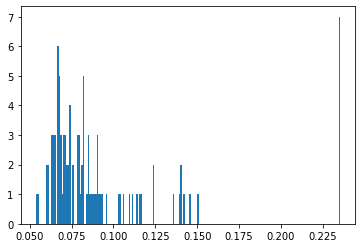

In [18]:
plt.hist(costs, bins=200)
plt.show()

We perform a gridsearch on the regularization parameter to find the best value. We use the test set to evaluate the performance of the model.

In [38]:
def grid_search_nn_lambdas(lambdas, avg_num, optmode="normal", max_iter=200, eta=0.01, progressbar = False, save=None):
    # This takes ~40 minute to run with 40 lambdas, avg_num = 10 and max_iter = 200
    # Grid search on regularization parameter
    costs_lam = []
    progress = 0

    for l in lambdas:
        if progressbar:
            progress += 1/len(lambdas)
            print(f"Progress: {100*progress:.2f}%", end="\r")
        # Average over avg_num runs
        cost = 0
        for _ in range(avg_num):
            layers = [n, 20, 10, 1]
            nn = NeuralNetwork(layers, activation="sigmoid", output_activation="sigmoid", regularization=l)
            w0 = nn.wb()

            w, gd = gradient_descent_execution(X_train, w0, z_train, nn, mode=optmode, max_iter=max_iter, eta=eta)
            cost += gd.costs[-1]
        cost /= avg_num
        costs_lam.append(cost)
    
    if save is not None:
        with open("Results/NNcancer_gridsearch.txt", "a") as f:
            # Create space
            f.write("\n\n")
            f.write(f"Best lambda: {lambdas[np.argmin(costs_lam)]}")
            # Save parameters
            f.write(f"Layers: {layers}, lambdas: {lambdas}, mode: {gd.mode}, avg_num: {avg_num}")
            # Save costs
            f.write(f"Costs: {costs_lam}")
    
    return costs_lam, lambdas[np.argmin(costs_lam)]



In [39]:
lambdas = np.logspace(-6, 0, 25)
costs_lam, best_lam = grid_search_nn_lambdas(lambdas, avg_num=40, optmode="rmsprop", max_iter=100, eta=0.01, progressbar=True, save="Results/NNcancer_gridsearch.txt")

c:\Users\leand\FYS-STK\FYS-STK3155-project-2\feedforward_nn.py:70: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


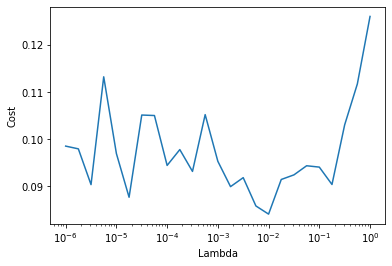

Best lambda: 0.01
[1.00000000e-06 1.77827941e-06 3.16227766e-06 5.62341325e-06
 1.00000000e-05 1.77827941e-05 3.16227766e-05 5.62341325e-05
 1.00000000e-04 1.77827941e-04 3.16227766e-04 5.62341325e-04
 1.00000000e-03 1.77827941e-03 3.16227766e-03 5.62341325e-03
 1.00000000e-02 1.77827941e-02 3.16227766e-02 5.62341325e-02
 1.00000000e-01 1.77827941e-01 3.16227766e-01 5.62341325e-01
 1.00000000e+00]


In [42]:
plt.semilogx(lambdas, costs_lam)
plt.xlabel("Lambda")
plt.ylabel("Cost")
plt.show()
# Print best lambda
print("Best lambda:", best_lam)
print(lambdas)


# Task d)

First, we are looking to uncover which modes and regularization parameters to use in our neural network:

In [43]:
import numpy as np
import matplotlib.pyplot as plt

from feedforward_nn import NeuralNetwork
from gradient_descent import GradientDescent
from regression_tools import accuracy

from sklearn.datasets import load_breast_cancer as wbc
from sklearn.model_selection import train_test_split

In [45]:
# Load data
data = wbc()
X = data.data
y = data.target

# Split data into training and test sets
X_train, X_test, z_train, z_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, z_train, z_val = train_test_split(X_train, z_train, test_size=0.2)
n = X_train.shape[1]

In [93]:
def optimal_reg_neural_network(X_train, 
                               z_train, 
                               X_val, 
                               z_val, 
                               layers, 
                               regularizationrange, 
                               momentum=0,
                               avg_num = 10,
                               optmode="normal", 
                               max_iter=200, 
                               eta=0.01,
                               activation="sigmoid",
                               output_activation="sigmoid",
                               ):
    """Returns the optimal regularization parameter for a neural network with the given parameters, taking the average over avg_num runs."""
    accuracy_val = []
    for reg in regularizationrange:
        # Average over avg_num runs
        acc = 0
        for _ in range(avg_num):
            nn = NeuralNetwork(layers, activation=activation, output_activation=output_activation, regularization=reg)
            w0 = nn.wb()
            batch_size = 16
            store_extra = True

            gd = GradientDescent(batch_size=batch_size, momentum_param=momentum, store_extra=store_extra, mode=optmode)
            w = gd.train(X_train, w0, z_train, nn, eta, max_iter)
            z_pred = np.around(nn.predict(X_val, w).flatten())
            acc += accuracy(z_pred, z_val)
        acc /= avg_num
        accuracy_val.append(acc)
    # Return best regularization parameter, corresponding accuracy and accuracy_val
    return regularizationrange[np.argmax(accuracy_val)], np.max(accuracy_val), accuracy_val
    

In [66]:

# Grid search on regularization parameter for each mode - low resolution, as we only want to find the best mode
modes = ["normal", "adagrad", "rmsprop", "adam"]
best_lam = []
best_acc = []
accuracy_val = []
for mode in modes:
    print(f"Mode: {mode}")
    lambdas = np.logspace(-10, 0, 10)
    # TODO: Fix adagrad
    if mode=="adagrad":
        best_lam_mode, best_acc_mode, accuracy_val_mode = optimal_reg_neural_network(X_train, z_train, X_val, z_val, [n, 20, 10, 1], lambdas, momentum=0.8, optmode=mode, avg_num=40, max_iter=80, eta=10)
    else:
        best_lam_mode, best_acc_mode, accuracy_val_mode = optimal_reg_neural_network(X_train, z_train, X_val, z_val, [n, 20, 10, 1], lambdas, optmode=mode, avg_num=40, max_iter=80, eta=0.01)
    best_lam.append(best_lam_mode)
    best_acc.append(best_acc_mode)
    accuracy_val.append(accuracy_val_mode)


Mode: normal


c:\Users\leand\FYS-STK\FYS-STK3155-project-2\feedforward_nn.py:70: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Mode: adagrad


c:\Users\leand\FYS-STK\FYS-STK3155-project-2\gradient_descent.py:138: RuntimeWarning: divide by zero encountered in true_divide
  return self.eta / np.sqrt(self.G)
c:\Users\leand\FYS-STK\FYS-STK3155-project-2\gradient_descent.py:108: RuntimeWarning: invalid value encountered in multiply
  return self.momentum * self.momentum_param - eta * model.gradient(X, w, y)


Mode: rmsprop
Mode: adam


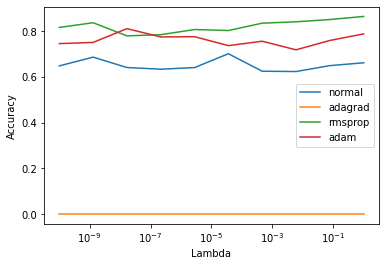

Mode	Best lambda	Accuracy
normal	3.59e-05	0.70
adagrad	1.00e-10	0.00
rmsprop	1.00e+00	0.86
adam	1.67e-08	0.81


In [67]:
# Plot accuracy vs. regularization parameter for each mode
for i in range(len(modes)):
    plt.semilogx(lambdas, accuracy_val[i], label=modes[i])
    plt.xlabel("Lambda")
    plt.ylabel("Accuracy")
    plt.legend()
plt.show()

# Print best regularization parameter for each mode as a table
print("Mode\tBest lambda\tAccuracy")
for i in range(len(modes)):
    print(f"{modes[i]}\t{best_lam[i]:.2e}\t{best_acc[i]:.2f}")

We see that rmsprop consistently outperforms the other modes, and choose this mode in our further analysis.

We now want to explore different activation functions for hidden layers.

In [95]:
# Perform grid search on regularization for each activation function
activations = ["linear", "sigmoid", "relu", "leaky_relu"]
best_lam = []
best_acc = []
accuracy_val = []
for activation in activations:
    print(f"Activation: {activation}")
    lambdas = np.logspace(-6, 3, 10)
    best_lam_mode, best_acc_mode, accuracy_val_mode = optimal_reg_neural_network(X_train, z_train, X_val, z_val, [n, 20, 10, 1], lambdas, optmode="rmsprop", avg_num=40, max_iter=100, eta=0.01, activation=activation)
    best_lam.append(best_lam_mode)
    best_acc.append(best_acc_mode)
    accuracy_val.append(accuracy_val_mode)


Activation: linear
Activation: sigmoid
Activation: relu
Activation: leaky_relu


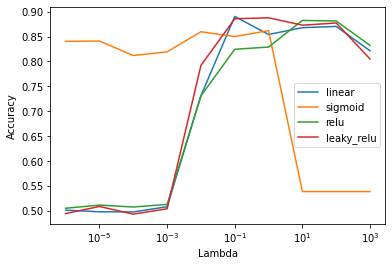

In [96]:
# Plot accuracy vs. regularization parameter for each activation function
for i in range(len(activations)):
    plt.semilogx(lambdas, accuracy_val[i], label=activations[i])
    plt.xlabel("Lambda")
    plt.ylabel("Accuracy")
    plt.legend()
plt.show()



Shocking. We see that sigmoid does better for most regularization parameters, until this parameter reaches high enough values. It appears linear og leaky_relu performs better here. We thus choose leaky_relu in our further analysis, and note that the regularization range we here need to consider seems to be from around 1e-1 to 1e3

In [100]:
def optimal_lr_neural_network(X_train,
                              z_train,
                              X_val,
                              z_val,
                              layers,
                              regularization,
                              lrrange,
                              momentum=0,
                              avg_num=10,
                              optmode="normal",
                              max_iter=200,
                              activation="sigmoid",
                              output_activation="sigmoid",
                              eta=0.01
                              ):
    """Returns the optimal learning rate for a neural network with the given parameters, taking the average over avg_num runs."""
    accuracy_val = []
    for lr in lrrange:
        # Average over avg_num runs
        acc = 0
        for _ in range(avg_num):
            nn = NeuralNetwork(layers, activation=activation, output_activation=output_activation, regularization=regularization)
            w0 = nn.wb()
            batch_size = 16
            store_extra = True

            gd = GradientDescent(batch_size=batch_size, momentum_param=momentum, store_extra=store_extra, mode=optmode)
            w = gd.train(X_train, w0, z_train, nn, lr, max_iter)
            z_pred = np.around(nn.predict(X_val, w).flatten())
            acc += accuracy(z_pred, z_val)
        acc /= avg_num
        accuracy_val.append(acc)
    # Return best learning rate, corresponding accuracy and accuracy_val
    return lrrange[np.argmax(accuracy_val)], np.max(accuracy_val), accuracy_val

In [102]:
# Perform grid search on learning rate for rmsprop
# TODO: Must be done for much higher iterations
lrrange = np.logspace(-5, 0, 10)
best_lr, best_acc, accuracy_val = optimal_lr_neural_network(X_train, z_train, X_val, z_val, [n, 20, 10, 1], 1, lrrange, optmode="rmsprop", avg_num=40, max_iter=80, eta=0.01, activation="leaky_relu")


c:\Users\leand\FYS-STK\FYS-STK3155-project-2\feedforward_nn.py:70: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


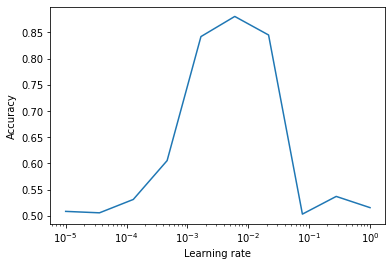

Best learning rate: 5.99e-03


In [103]:
# Plot accuracy vs. learning rate for rmsprop
plt.semilogx(lrrange, accuracy_val)
plt.xlabel("Learning rate")
plt.ylabel("Accuracy")
plt.show()

# Print best learning rate for rmsprop
print(f"Best learning rate: {best_lr:.2e}")

We see that the optimal accuracy is reached with a learning rate of around 0.006, and will use this going forward.